In [313]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
-
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_rows', 500)

In [170]:
# Reading the file:
urldata = pd.read_csv("TimestampwithURL(Aug-October 2020).csv")
#pd.options.display.float_format = '{:20,.2f}'.format

In [171]:
urldata.head()


,panelistid,timestamp_utc,pageurl
0,C153182421,1.602870e+09,0ruq-alternate.app.link:443
1,C86864690,1.598914e+09,6g02fk.tdum.alibaba.com:443
2,C2064046948,1.603043e+09,a.co
3,C141517021,1.601651e+09,a.co:443
4,C2090210045,1.599200e+09,a.co:443


In [172]:
urldata['datetime'] = pd.to_datetime(urldata['timestamp_utc'], unit = 's', errors = 'ignore')
# Extract dates from datetime:
urldata['datetime'] = urldata['datetime'].apply(pd.to_datetime)

In [173]:
urldata.dtypes

panelistid               object
timestamp_utc           float64
pageurl                  object
datetime         datetime64[ns]
dtype: object

In [174]:
# Using this handy package to see some summary statistics
from pandas_profiling import ProfileReport
prof = ProfileReport(urldata)
prof.to_file(output_file='output.html')

C:\Users\anuj - laptop\AppData\Roaming\Python\Python37\site-packages\pandas_profiling\model\summary.py:419: UserWarning: Discarding nonzero nanoseconds in conversion
  type_to_func[series_description["type"]](series, series_description)


In [175]:
# Checking for null values: No nulls are there, 
# however as we see below about 28% of date time values > current year which is odd
urldata.isna().sum()

panelistid       0
timestamp_utc    0
pageurl          0
datetime         0
dtype: int64

In [452]:
# 1) Data processing for 1 timestamp values:  Deriving new columns for date time - these will be used for trend analysis
urldata['date'] = urldata['datetime'].dt.date
urldata['year'] = pd.DatetimeIndex(urldata['date']).year
urldata['month'] = pd.DatetimeIndex(urldata['date']).month
urldata['month_name'] = pd.DatetimeIndex(urldata['date']).month_name()
urldata['day'] = pd.DatetimeIndex(urldata['date']).day
urldata['weekday'] = pd.DatetimeIndex(urldata['date']).day_name()
urldata['week_of_month'] = np.ceil(pd.DatetimeIndex(urldata['date']).day/7)
urldata['hour'] = np.ceil(pd.DatetimeIndex(urldata['datetime']).hour)

In [177]:
urldata['year'].value_counts()

2020    21570
2071     3098
1970     1655
2070     1197
2121      866
2122      554
2172      360
2171      185
2223      166
2222      158
2173      138
2224       28
2221       24
Name: year, dtype: int64

In [178]:
# Year values > 2020, way into the future dont make sense for such clickstream data
# Exclude them from the analysis!? or do data cleaning (not possible to arrive at a method of data cleaning in this case!)

In [179]:
# Finding the min date in 2020 for this analysis:
urldata.date[urldata['year'] == 2020].min(), urldata.date[urldata['year'] == 2020].max()

(datetime.date(2020, 5, 6), datetime.date(2020, 11, 1))

In [180]:
urldata.dtypes

panelistid               object
timestamp_utc           float64
pageurl                  object
datetime         datetime64[ns]
date                     object
year                      int64
month                     int64
month_name               object
day                       int64
weekday                  object
week_of_month           float64
dtype: object

In [331]:
# Since we have almost continuous values since 6th May 2020 to 1st Nov 2020,
# deriving a new variable week_since_6thmay2020 to assing a week number
may6th = pd.Timestamp("2020-05-06")
urldata['may6th2020'] = pd.Timestamp("2020-05-06")

#urldata['week_since_6thmay2020'] = urldata.apply((urldata.datetime - may6th).dt.days)

urldata['week_since_6thmay2020'] = np.ceil((pd.to_datetime(urldata['date']) - urldata['may6th2020']).dt.days/7)


In [453]:
urldata.head()

,panelistid,timestamp_utc,pageurl,datetime,date,year,month,month_name,day,weekday,week_of_month,may6th2020,week_since_6thmay2020,tld_all,tld,subdomain,hour
0,C153182421,1.602870e+09,0ruq-alternate.app.link:443,2020-10-16 17:44:12,2020-10-16,2020,10,October,16,Friday,3.0,2020-05-06,24.0,"(0ruq-alternate, app, link)",app.link,0ruq-alternate,17.0
1,C86864690,1.598914e+09,6g02fk.tdum.alibaba.com:443,2020-08-31 22:47:10,2020-08-31,2020,8,August,31,Monday,5.0,2020-05-06,17.0,"(6g02fk.tdum, alibaba, com)",alibaba.com,6g02fk.tdum,22.0
2,C2064046948,1.603043e+09,a.co,2020-10-18 17:36:57,2020-10-18,2020,10,October,18,Sunday,3.0,2020-05-06,24.0,"(, a, co)",a.co,,17.0
3,C141517021,1.601651e+09,a.co:443,2020-10-02 15:02:08,2020-10-02,2020,10,October,2,Friday,1.0,2020-05-06,22.0,"(, a, co)",a.co,,15.0
4,C2090210045,1.599200e+09,a.co:443,2020-09-04 06:08:08,2020-09-04,2020,9,September,4,Friday,1.0,2020-05-06,18.0,"(, a, co)",a.co,,6.0


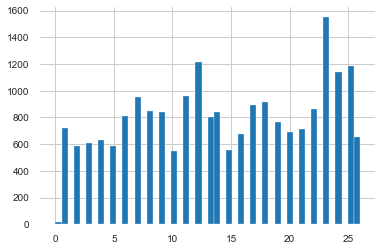

In [333]:
# Getting a histogram - distribution of the week_since_6thmay2020 variable:

urldata.week_since_6thmay2020[urldata.year == 2020].hist(bins = 50)

In [317]:
# As we can see for the time period between may 2020 to nov 2020 we have evenly distributed clickstream data
# this is the time period that will be considdered for the final analysis, will exlclude the outliers!

In [318]:
# Getting the Current UNIX timestamp:

current_timestamp = pd.Timestamp.now()
(current_timestamp - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')  
# Int64Index([1547559000], dtype='int64')

1632604637

In [319]:
# Getting the % of values in dataset > current time stamp

urldata[urldata['timestamp_utc'] > 1632592141]

,panelistid,timestamp_utc,pageurl,datetime,date,year,month,month_name,day,weekday,week_of_month,may6th2020,week_since_6thmay2020,tld_all,tld,subdomain
6,C47629656,3.190739e+09,a.co:443,2071-02-09 20:30:23,2071-02-09,2071,2,February,9,Monday,2.0,2020-05-06,2649.0,"(, a, co)",a.co,
7,C58695794,3.196774e+09,a.co:443,2071-04-20 16:51:09,2071-04-20,2071,4,April,20,Monday,3.0,2020-05-06,2659.0,"(, a, co)",a.co,
8,C76064428,3.192481e+09,a.co:443,2071-03-02 00:15:43,2071-03-02,2071,3,March,2,Monday,1.0,2020-05-06,2652.0,"(, a, co)",a.co,
16,C1987747526,3.191865e+09,aax-us-east.amazon-adsystem.com/x/c/QrJDdKHIbC...,2071-02-22 21:08:04,2071-02-22,2071,2,February,22,Sunday,4.0,2020-05-06,2651.0,"(aax-us-east, amazon-adsystem, com)",amazon-adsystem.com,aax-us-east
30,C49922060,3.204984e+09,abercrombie.com/shop/ca/mens-clearance?filtere...,2071-07-24 17:22:33,2071-07-24,2071,7,July,24,Friday,4.0,2020-05-06,2673.0,"(, abercrombie, com)",abercrombie.com,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29990,C1988008722,3.180759e+09,https://ca.shopatshowcase.com/collections/head...,2070-10-17 08:17:56,2070-10-17,2070,10,October,17,Friday,3.0,2020-05-06,2633.0,"(ca, shopatshowcase, com)",shopatshowcase.com,ca
29992,C88202554,4.790725e+09,https://ca.shopatshowcase.com/collections/health,2121-10-24 04:50:46,2121-10-24,2121,10,October,24,Friday,4.0,2020-05-06,5295.0,"(ca, shopatshowcase, com)",shopatshowcase.com,ca
29995,C88202554,4.790723e+09,https://ca.shopatshowcase.com/collections/heal...,2121-10-24 04:22:46,2121-10-24,2121,10,October,24,Friday,4.0,2020-05-06,5295.0,"(ca, shopatshowcase, com)",shopatshowcase.com,ca
29997,C88202554,3.193818e+09,https://ca.shopatshowcase.com/collections/heal...,2071-03-17 11:39:12,2071-03-17,2071,3,March,17,Tuesday,3.0,2020-05-06,2654.0,"(ca, shopatshowcase, com)",shopatshowcase.com,ca


In [334]:
# 2) Data processing for pageurl:  Deriving new columns for url- top level domain and others
# we can use Regex: regular expressions to get the the top level domain anb subdomain,
# however since the urls are not in a uniform format this can be tricky
# python has a library for this: tldextract

import tldextract
ext = tldextract.extract('http://forums.news.cnn.com/')
ext


ExtractResult(subdomain='forums.news', domain='cnn', suffix='com')

In [335]:
urldata['tld_all'] = urldata.pageurl.apply(tldextract.extract)
#.str.split(",", expand = True)

urldata['tld'] = urldata['pageurl'].apply(lambda url: tldextract.extract(url).domain  + "." + tldextract.extract(url).suffix)
urldata['subdomain'] = urldata['pageurl'].apply(lambda url: tldextract.extract(url).subdomain)

# Doing a Spot Check for a few values to see if we are getting the correct, 
# values for top level domain and subdomain etc

urldata[(urldata['timestamp_utc'] == 1590160552) | (urldata['timestamp_utc'] == 1590970889)]


In [350]:
urldata.head(5)

,panelistid,timestamp_utc,pageurl,datetime,date,year,month,month_name,day,weekday,week_of_month,may6th2020,week_since_6thmay2020,tld_all,tld,subdomain
0,C153182421,1.602870e+09,0ruq-alternate.app.link:443,2020-10-16 17:44:12,2020-10-16,2020,10,October,16,Friday,3.0,2020-05-06,24.0,"(0ruq-alternate, app, link)",app.link,0ruq-alternate
1,C86864690,1.598914e+09,6g02fk.tdum.alibaba.com:443,2020-08-31 22:47:10,2020-08-31,2020,8,August,31,Monday,5.0,2020-05-06,17.0,"(6g02fk.tdum, alibaba, com)",alibaba.com,6g02fk.tdum
2,C2064046948,1.603043e+09,a.co,2020-10-18 17:36:57,2020-10-18,2020,10,October,18,Sunday,3.0,2020-05-06,24.0,"(, a, co)",a.co,
3,C141517021,1.601651e+09,a.co:443,2020-10-02 15:02:08,2020-10-02,2020,10,October,2,Friday,1.0,2020-05-06,22.0,"(, a, co)",a.co,
4,C2090210045,1.599200e+09,a.co:443,2020-09-04 06:08:08,2020-09-04,2020,9,September,4,Friday,1.0,2020-05-06,18.0,"(, a, co)",a.co,


In [454]:
# this completes the data pre-processing and we can start the analysis,
# we will save the dataset with only 2020 data to a new dataset: urldata_2020 and do the analysis on that!
urldata_2020 = urldata[urldata.year == 2020]
urldata_2020.shape

(21570, 17)

In [353]:
#1) Most Frequetly visited websites!

temp = DataFrame(urldata.tld.value_counts())
temp[temp.tld > 10]

,tld
amazon.ca,11508
costco.ca,1322
homedepot.ca,1126
amazon.com,1125
shoppersdrugmart.ca,987
ebay.ca,975
bestbuy.ca,862
gapcanada.ca,754
etsy.com,587
mypoints.com,493


In [356]:
# based on just the raw no of hits: the most commonly visited top 10 websites are:
#amazon.ca, costco.ca, homedepot.ca, amazon.com, shopporsdrugmart.ca, ebay.ca, bestbuy.ca
# this metric - the count of no of hits on a domain is slightly misleading,
# since 1 domain can have a series of pages which 1 unique user can visit in 1 session
# as 1 user can visit multiple pages of same domain, 
# hence it is important to count only unique visitors of the day by each website to get a better sense of popularity

# KPI 1) Most frequent visited website: no of unique daily visitors - add all days of the week - no of unique weekly visitors

In [357]:
# plotting the no of unique users by tld: X-axis date, y axis no of unique users: for top 25 domains

nunique_users_day = DataFrame(urldata_2020.groupby(['tld','date','week_since_6thmay2020']).agg({'panelistid':['nunique']})).reset_index()
#nunique_users_day.columns = nunique_users.columns.droplevel()
nunique_users_day.columns = ['tld','date','week','nunique']
nunique_users_day.columns
type(nunique_users_day)
#nunique_users_day

nunique_users_day_df = DataFrame(nunique_users_day)
nunique_users_day_df.columns, nunique_users_day_df.shape

nunique_users_week = DataFrame(nunique_users_day.groupby(['tld','week'])['nunique'].sum()).reset_index()
#nunique_users_week.columns = nunique_users.columns.droplevel()
#nunique_users_week.columns = ['tld','week','nunique']
#nunique_users_week

# We take an sum of daily unique users by week and aggregate top level by website

most_frequent_websites = DataFrame(nunique_users_week.groupby(['tld'])['nunique'].mean()).reset_index().sort_values(by = 'nunique', ascending = False)
# Top 20 most visited website by Avg unique users per week
most_frequent_websites.head(20)


Index(['tld', 'date', 'week', 'nunique'], dtype='object')

pandas.core.frame.DataFrame

(Index(['tld', 'date', 'week', 'nunique'], dtype='object'), (4281, 4))

,tld,nunique
29,amazon.ca,46.115385
32,amazon.com,13.851852
166,costco.ca,12.115385
316,homedepot.ca,9.333333
218,ebay.ca,9.153846
86,bestbuy.ca,8.423077
520,shoppersdrugmart.ca,7.307692
238,etsy.com,6.400000
275,gapcanada.ca,4.615385
416,mypoints.com,4.476190


<Figure size 720x576 with 0 Axes>

Text(0.5, 1.0, 'No of daily unique vistors')

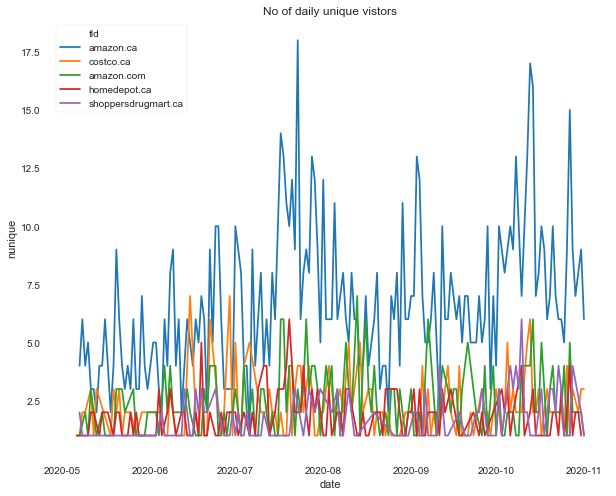

In [360]:
# plotting the no of unique users by tld: X-axis date by day, y axis no of unique users: for top 25 domains
plt.figure(figsize=(10,8))
plt.title("No of daily unique vistors")
sns.lineplot(data = nunique_users_day, x='date', y='nunique' , hue = 'tld', hue_order=pd.value_counts(urldata_2020['tld']).iloc[:5].index )

<Figure size 720x576 with 0 Axes>

Text(0.5, 1.0, 'No of aggregate weekly unique vistors')

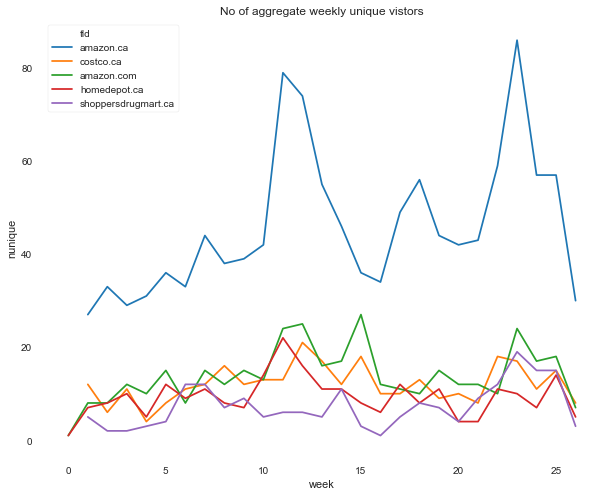

In [361]:

# Repeating the same above but by week: sum the no of unique visitors by week to get weekly number
plt.figure(figsize=(10,8))
plt.title("No of aggregate weekly unique vistors")
sns.lineplot(data = nunique_users_week, x='week', y='nunique' , hue = 'tld', hue_order=pd.value_counts(urldata_2020['tld']).iloc[:5].index )

In [362]:
#As we can see from the above chart, 
#the top5/top 10 domains are consistent week over week, with amazon.ca being the top domain most frequently visited
# the other top domains are: costco.ca, amazon.com, homedepot.ca - with a very closely distributed avg no of new user visits
# shoppersdrugmart.ca is the 5th most frequently visited domain

In [363]:
#QUESTION 2: ANALYSIS OF web-behaviour for the top domains and how users interact with them 

# metric2 : no of avg pages visited by a user on a domain per day - this is to measure the user engagement on the domain

In [376]:
# calculating metric 2 (only for the top 20 domains): 

tld_user_daily_pages_count_1 = DataFrame(urldata_2020.groupby(['tld','panelistid','date','week_since_6thmay2020']).agg({'pageurl':['count']})).reset_index()
#nunique_users_day.columns = nunique_users.columns.droplevel()
tld_user_daily_pages_count_1.columns = ['tld','user','date','week','count_pages']
tld_user_daily_pages_count_2 = DataFrame(tld_user_daily_pages_count_1.groupby(['tld','date','week'])['count_pages'].mean()).reset_index()
tld_user_daily_pages_count_2.columns = ['tld','date','week','avg_count_pages_by_user']
tld_user_daily_pages_count_2.columns
# since there can be days on high user engagement on a domain, we want to get the weekly average to even out the numbers and get 
# a more accuracte representation of the engagement
tld_user_daily_pages_count_3 = DataFrame(tld_user_daily_pages_count_2.groupby(['tld','week'])['avg_count_pages_by_user'].mean()).reset_index()
tld_user_daily_pages_count_3.columns = ['tld','week','avg_count_pages_by_user']
#type(tld_user_daily_pages_count)
#tld_user_daily_pages_count_1.head()
#tld_user_daily_pages_count_2.head()
# Finally getting the overall average 

tld_user_daily_pages_count_3.sort_values(by = ['tld','week','avg_count_pages_by_user'], ascending = True)

Index(['tld', 'date', 'week', 'avg_count_pages_by_user'], dtype='object')

,tld,week,avg_count_pages_by_user
0,1stdibs.com,17.0,1.0
1,247mirror.com,19.0,1.0
2,247mirror.com,20.0,1.0
3,2carpros.com,21.0,1.0
4,6dollarshirts.com,21.0,1.0
...,...,...,...
2345,zulily.com,3.0,1.0
2346,zulily.com,4.0,1.0
2347,zulily.com,21.0,2.0
2348,zulily.com,22.0,2.0


In [ ]:
#from the above table we can see that for many domains data is very sporadic, 
#that is a lot of weeks are missing as there was no traffic on the domain, 
#so it only makes sense to look at this metric for the top domains!

<Figure size 720x576 with 0 Axes>

Text(0.5, 1.0, 'Avg no of Pages visited on Domain per user per day')

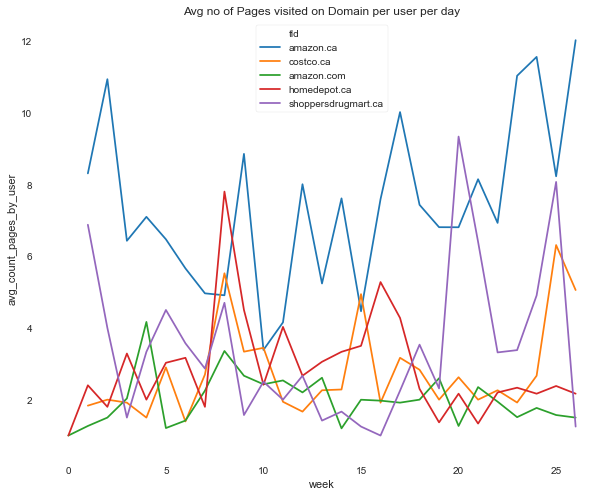

In [373]:
# by week: sum the no of unique visitors by week to get weekly number
plt.figure(figsize=(10,8))
plt.title("Avg no of Pages visited on Domain per user per day")
sns.lineplot(data =tld_user_daily_pages_count_3, x='week', y='avg_count_pages_by_user' , hue = 'tld', hue_order=pd.value_counts(urldata_2020['tld']).iloc[:5].index )

In [472]:
#QUESTION 2: ANALYSIS OF web-behaviour for the top domains and how users interact with them - ANY GROUPS or Trends

# metric3: for the top10 domains get the - domains which the users have visited simultaneously by a particular user on the same date
# this metric will mesaure if there are any groups of websites visited together

In [574]:
# to do this we will first get the data at this level: domain, user, date

temp1 = urldata_2020.drop_duplicates(['tld','panelistid','date'])[['tld','panelistid','date']]
urldata_2020.shape, temp1.shape, temp1.head()

# on temp1 we count by tld, date the no of unique users
aggregate_by_tld1 = temp1.groupby(['tld','date']).count().reset_index()
#aggregate_by_tld1.columns = aggregate_by_tld1.columns.droplevel()
aggregate_by_tld1.columns = ['tld','date','count_unique_visitors']
aggregate_by_tld2 = aggregate_by_tld1.groupby(['tld']).sum().reset_index()
aggregate_by_tld2.columns = ['tld','count_unique_visitors']
aggregate_by_tld3 = aggregate_by_tld2[aggregate_by_tld2['tld'].isin(top10)]
print("\n ############# aggregate by tld3 ##############")
aggregate_by_tld3

# using a self join, join back on the same dataset 'temp1' to get the list of all other domains visited in the same date by the same user
temp2 = temp1.merge(temp1, how = 'left', on = ['panelistid', 'date'])
temp2.shape

# we need to drop the rows where tld_x = tld_y - same domain
temp3 = temp2.drop(temp2[temp2['tld_x'] == temp2['tld_y']].index)
temp3.shape
temp3.head()

# This analysis is more relevant for the top 10 domains only, since user traffic is rather low to quantify on other domains

top10 = DataFrame(pd.value_counts(urldata_2020['tld'])).head(10).index.to_list()
top10

# filtering temp3 where tld_x in top10
temp4 = temp3[temp3['tld_x'].isin(top10)]
temp4.shape
temp4

# getting the no of unique users at: tld_x, tld_y level
temp5 = temp4.drop(['date'], axis = 1).groupby(['tld_x','tld_y']).count().reset_index()
temp5.columns = ['tld_x','tld_y','count_unique_visitors']   
temp5['count_unique_visitors'] = pd.to_numeric(temp5['count_unique_visitors'], errors='coerce')
temp6 = temp5.sort_values(by = ['tld_x','tld_y','count_unique_visitors'], ascending = [True, True, False])
temp6.head(5)

# joining the aggregate_by_tld3 and tld6 datasets to get the graph and KPI:

temp7 = temp6.merge(aggregate_by_tld3, how = 'left', left_on='tld_x', right_on = 'tld')
temp7['ratio_of_no_users_visiting_both_sites'] = temp7['count_unique_visitors_x'] /  temp7['count_unique_visitors_y']
#temp7['ratio_of_no_users_visiting_both_sites'] = temp7['ratio_of_no_users_visiting_both_sites'].astype('int64')
temp8 = temp7.drop(['tld_x','count_unique_visitors_x'], axis = 1).sort_values(by = ['tld','ratio_of_no_users_visiting_both_sites'], ascending = [True, False])
temp8.head(500)



((21570, 17),
 (6469, 3),
            tld   panelistid        date
 0     app.link   C153182421  2020-10-16
 1  alibaba.com    C86864690  2020-08-31
 2         a.co  C2064046948  2020-10-18
 3         a.co   C141517021  2020-10-02
 4         a.co  C2090210045  2020-09-04)


 ############# aggregate by tld3 ##############


,tld,count_unique_visitors
29,amazon.ca,1199
32,amazon.com,374
86,bestbuy.ca,219
166,costco.ca,315
218,ebay.ca,238
238,etsy.com,160
275,gapcanada.ca,120
316,homedepot.ca,252
416,mypoints.com,94
520,shoppersdrugmart.ca,190


(12497, 4)

(6028, 4)

,tld_x,panelistid,date,tld_y
1,app.link,C153182421,2020-10-16,letgo.com
2,app.link,C153182421,2020-10-16,amazon.cn
4,alibaba.com,C86864690,2020-08-31,taobao.com
7,a.co,C141517021,2020-10-02,amazon.de
8,a.co,C141517021,2020-10-02,amazon.it


['amazon.ca',
 'costco.ca',
 'amazon.com',
 'homedepot.ca',
 'shoppersdrugmart.ca',
 'ebay.ca',
 'gapcanada.ca',
 'bestbuy.ca',
 'mypoints.com',
 'etsy.com']

(2644, 4)

,tld_x,panelistid,date,tld_y
77,shoppersdrugmart.ca,C137922266,2020-10-27,brooksbrothers.com
80,shoppersdrugmart.ca,C1988355833,2020-10-06,columbia.com
82,shoppersdrugmart.ca,C88019855,2020-10-20,costco.ca
83,shoppersdrugmart.ca,C88019855,2020-10-20,googleadservices.com
97,ebay.ca,C1989169472,2020-05-08,amazon.ca
...,...,...,...,...
11991,shoppersdrugmart.ca,C132100627,2020-09-18,iherb.com
11997,shoppersdrugmart.ca,C2141463401,2020-06-02,amazon.ca
11998,shoppersdrugmart.ca,C2141463401,2020-06-02,amzn.to
12004,shoppersdrugmart.ca,C132100627,2020-10-28,iherb.com


,tld_x,tld_y,count_unique_visitors
0,amazon.ca,a.co,1
1,amazon.ca,abercrombie.com,4
2,amazon.ca,ae.com,1
3,amazon.ca,aldoshoes.com,1
4,amazon.ca,alibaba.com,3


,tld_y,tld,count_unique_visitors_y,ratio_of_no_users_visiting_both_sites
11,amazon.com,amazon.ca,1199,0.121768
57,costco.ca,amazon.ca,1199,0.060050
99,homedepot.ca,amazon.ca,1199,0.049208
70,ebay.ca,amazon.ca,1199,0.048374
34,bestbuy.ca,amazon.ca,1199,0.040867
72,ebay.com,amazon.ca,1199,0.022519
79,etsy.com,amazon.ca,1199,0.021685
94,google.com,amazon.ca,1199,0.018349
24,amzn.to,amazon.ca,1199,0.012510
31,bedbathandbeyond.ca,amazon.ca,1199,0.012510


In [612]:

# applying a rolling / rank function to just get the top5 per domain

temp8["RANK"] = temp8.groupby("tld")["ratio_of_no_users_visiting_both_sites"].rank(method="first", ascending=False)
temp9 = temp8[temp8.RANK <=5]
temp9.rename(columns={"tld_y": "secondary_domain", "tld": "primary_domain", "count_unique_visitors_y": "primary_unique_visitors", "ratio_of_no_users_visiting_both_sites": "secondary_visit_ratio", "RANK": "RANK"},inplace = True)


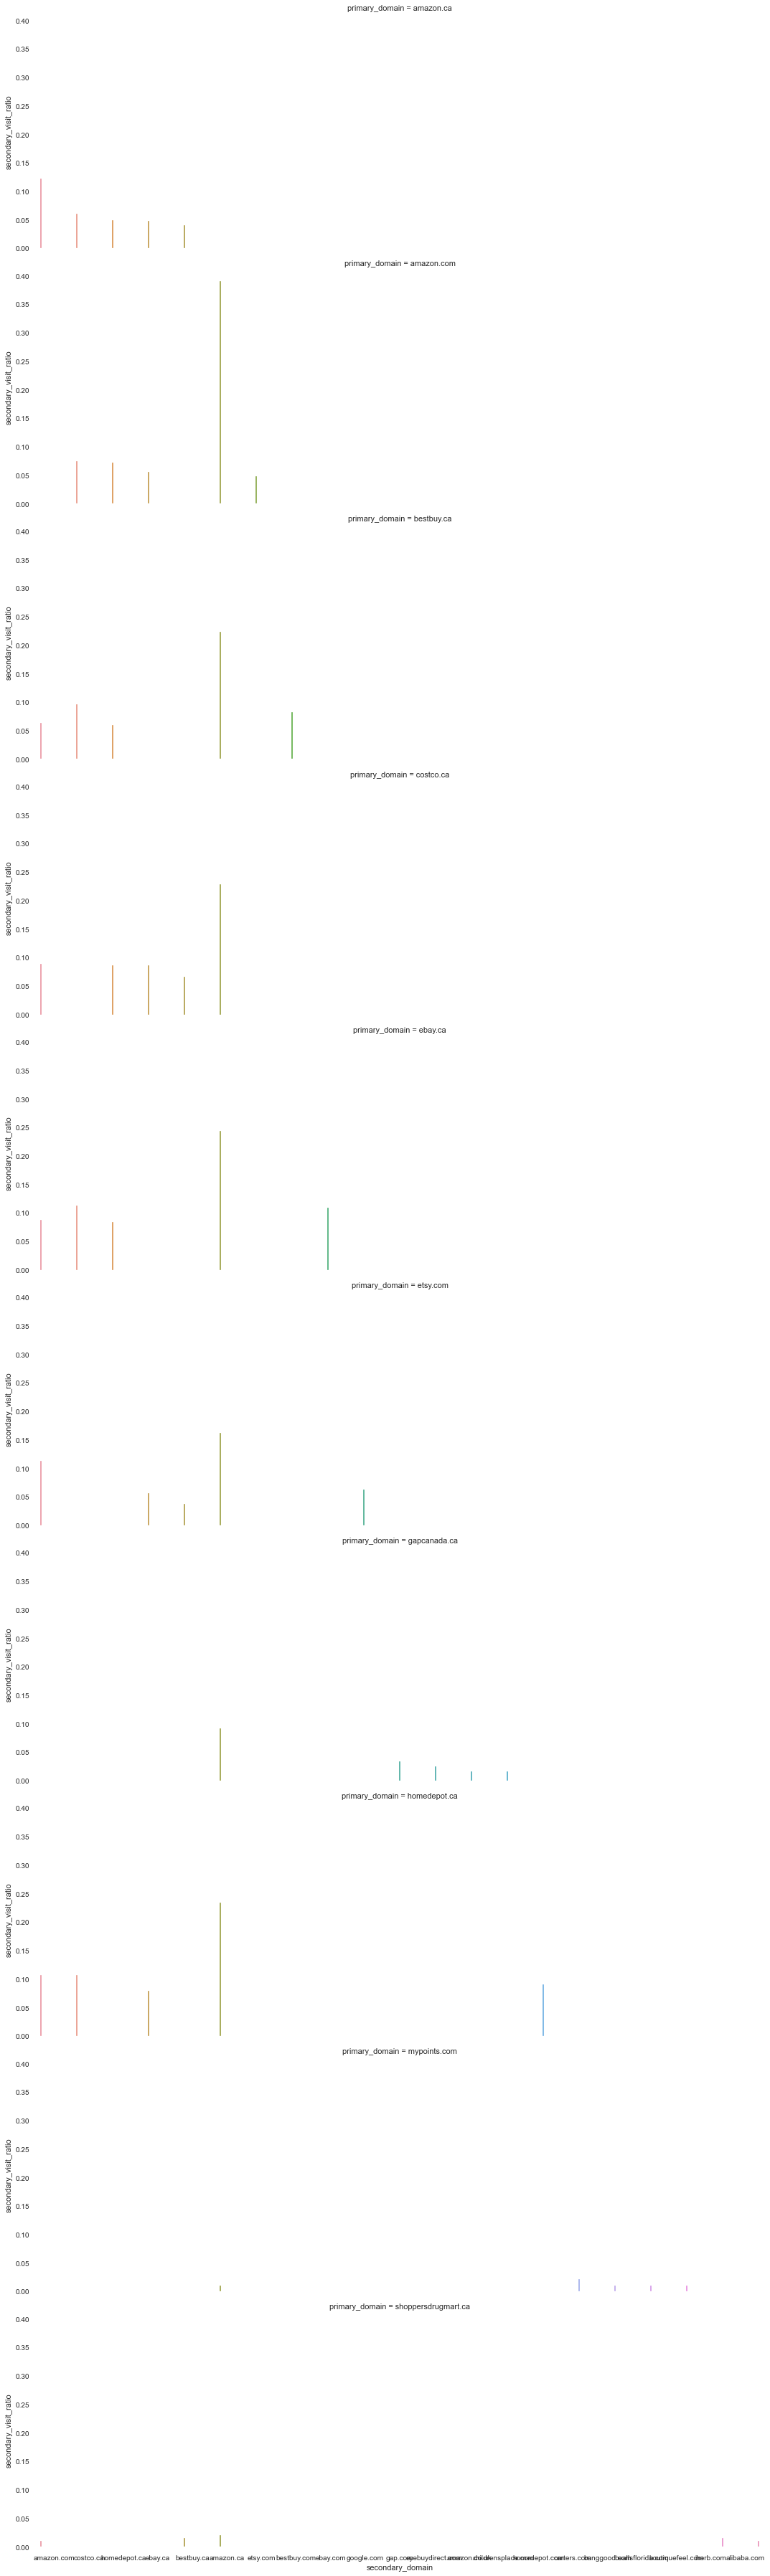

In [615]:
# finally for the top 10 domains, plotting which are the other domains visited simultaneously and what the ratio
# here visit ratio is defnied as for every 1 visit of a domian what is the avg visit of the secondary domain!

#fig, ax = plt.subplots(figsize=(20,20))
#plt.title("most frequently visited secondary domains for a given primary domain")
sns.catplot(row = 'primary_domain', height = 5, aspect=3, x="secondary_domain", y="secondary_visit_ratio", hue="secondary_domain", data=temp9, kind = 'bar')

In [ ]:
# This is very insightfyl! most of the top domains have secondary domain visit ratios which are quite high

In [583]:
top10

['amazon.ca',
 'costco.ca',
 'amazon.com',
 'homedepot.ca',
 'shoppersdrugmart.ca',
 'ebay.ca',
 'gapcanada.ca',
 'bestbuy.ca',
 'mypoints.com',
 'etsy.com']

(         user  avg_websites_visited_daily
 0  C129639566                    2.000000
 1  C131244695                    1.666667
 2  C131251425                    1.000000
 3  C131268840                    1.000000
 4  C131293289                    1.500000,
          user  avg_websites_visited_daily
 0  C129639566                         2.0
 1  C131244695                         1.0
 2  C131251425                         1.0
 3  C131268840                         1.0
 4  C131293289                         1.5)

Text(0.5, 1.0, 'Daily Avg Domains by User')

(array([579.,  51.,   7.,   5.,   0.,   1.,   1.,   3.,   0.,   1.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <a list of 10 Patch objects>)

Text(0.5, 1.0, 'Daily Median Domains by User')

(array([586.,  45.,   7.,   4.,   0.,   1.,   1.,   3.,   0.,   1.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <a list of 10 Patch objects>)

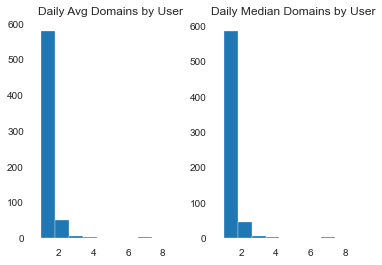

In [415]:
# High level analysis of web traffic

#1) distributiuon of website visited per day - user engagement
# we will look at both mean and median since data can be highly skewed

websites_visited_per_day_1 = DataFrame(urldata_2020.groupby(['panelistid','date','week_since_6thmay2020']).agg({'tld':['nunique']})).reset_index()
#websites_visited_per_day_1.columns = nunique_users.columns.droplevel()
websites_visited_per_day_1.columns = ['user','date','week','nunique']
websites_visited_per_day_2 = DataFrame(websites_visited_per_day_1.groupby(['user']).agg({'nunique':['mean']})).reset_index()
websites_visited_per_day_3 = DataFrame(websites_visited_per_day_1.groupby(['user']).agg({'nunique':['median']})).reset_index()
websites_visited_per_day_2.columns = ['user','avg_websites_visited_daily']
websites_visited_per_day_3.columns = ['user','avg_websites_visited_daily']
#type(websites_visited_per_day_2)
websites_visited_per_day_2.head(), websites_visited_per_day_3.head()

fig.subplots_adjust(wspace=2)
plt.subplot(1, 2, 1)
#plt.figure(figsize=(4,3))
plt.title('Daily Avg Domains by User')
plt.hist(websites_visited_per_day_2.avg_websites_visited_daily)
plt.subplot(1, 2, 2)
#plt.figure(figsize=(4,3))
plt.title('Daily Median Domains by User')
plt.hist(websites_visited_per_day_3.avg_websites_visited_daily)

plt.show()

In [416]:
# Max users go to only 1 domain, while a few164719 users visit 2 domains, the proportion of users visiting more than 2 domain is very low

In [432]:
# High level analysis of web traffic

#2) distributiuon of time spent by user per day - user engagement
# we will look at both mean and median since data can be highly skewed
# by a particular date get the min and max timestamp and then get the difference


user_time_spent_per_day_1 = DataFrame(urldata_2020.groupby(['panelistid','date']).agg({'timestamp_utc':['min'] })).reset_index()
user_time_spent_per_day_1.columns = ['user','date','min_time_stamp']

user_time_spent_per_day_2 = DataFrame(urldata_2020.groupby(['panelistid','date']).agg({'timestamp_utc':['max'] })).reset_index()
user_time_spent_per_day_2.columns = ['user','date','max_time_stamp']
#user_time_spent_per_day_2

# Joining the 2 datasets to get both min and max values in the same table:
user_time_spent_per_day_3 = user_time_spent_per_day_1.merge(user_time_spent_per_day_2, on = ['user','date'], how = 'left')
user_time_spent_per_day_3["daily_time_spent_mins"] = (user_time_spent_per_day_3.max_time_stamp - user_time_spent_per_day_3.min_time_stamp)/60
user_time_spent_per_day_3

user_time_spent_per_day_4 = DataFrame(user_time_spent_per_day_3.groupby(['user']).agg({'daily_time_spent_mins':['mean'] })).reset_index()
user_time_spent_per_day_4.columns = ['user','avg_time_spent_minutes']
user_time_spent_per_day_5 = DataFrame(user_time_spent_per_day_3.groupby(['user']).agg({'daily_time_spent_mins':['mean'] })).reset_index()
user_time_spent_per_day_5.columns = ['user','avg_time_spent_minutes']

,user,date,min_time_stamp,max_time_stamp,daily_time_spent_mins
0,C129639566,2020-09-15,1.600181e+09,1.600190e+09,147.783333
1,C131244695,2020-09-04,1.599223e+09,1.599223e+09,0.066667
2,C131244695,2020-09-06,1.599352e+09,1.599408e+09,933.100000
3,C131244695,2020-09-11,1.599817e+09,1.599823e+09,95.950000
4,C131251425,2020-10-16,1.602883e+09,1.602883e+09,0.000000
...,...,...,...,...,...
4682,C93297548,2020-07-27,1.595843e+09,1.595843e+09,0.000000
4683,C93539742,2020-08-16,1.597603e+09,1.597603e+09,0.000000
4684,C93654270,2020-08-03,1.596473e+09,1.596473e+09,0.000000
4685,C93654270,2020-09-22,1.600785e+09,1.600785e+09,0.133333


Text(0.5, 1.0, 'Daily AvgTime by User (minutes)')

(array([389.,  28.,  23.,  41.,  39.,  37.,  18.,  24.,   9.,  14.,   8.,
          6.,   0.,   2.,   4.,   0.,   1.,   2.,   2.,   0.]),
 array([  0,   5,  10,  15,  30,  60,  90, 120, 150, 180, 210, 240, 270,
        300, 330, 360, 390, 420, 450, 480, 510]),
 <a list of 20 Patch objects>)

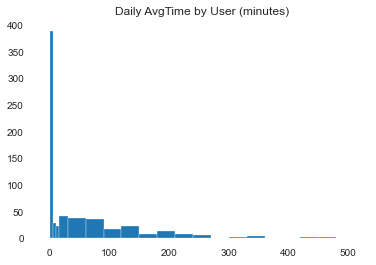

Text(0.5, 1.0, 'Daily MedianTime by User (minutes)')

(array([389.,  28.,  23.,  41.,  39.,  37.,  18.,  24.,   9.,  14.,   8.,
          6.,   0.,   2.,   4.,   0.,   1.,   2.,   2.,   0.]),
 array([  0,   5,  10,  15,  30,  60,  90, 120, 150, 180, 210, 240, 270,
        300, 330, 360, 390, 420, 450, 480, 510]),
 <a list of 20 Patch objects>)

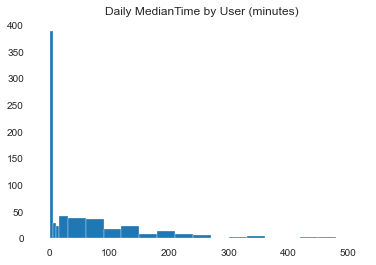

In [449]:
# for distribution of the avg daily time spent we will look at both mean and median since data can be highly skewed

fig.subplots_adjust(wspace=75, hspace = 75)
#plt.subplot(2, 1, 1)
#plt.figure(figsize=(8,6))
plt.title('Daily AvgTime by User (minutes)')
plt.hist(user_time_spent_per_day_5.avg_time_spent_minutes, bins = [0,5,10,15,30,60,90,120,150,180,210,240,270,300,330,360,390,420,450,480,510])
plt.show()
#plt.subplot(2, 1, 2)
#plt.figure(figsize=(8,6))
plt.title('Daily MedianTime by User (minutes)')
plt.hist(user_time_spent_per_day_5.avg_time_spent_minutes, bins = [0,5,10,15,30,60,90,120,150,180,210,240,270,300,330,360,390,420,450,480,510])
plt.show()



In [ ]:
# As we can observe above, most users spend between 0-5 mins on an average, so we can conclude that user engagement 
# in this clickstream dataset is rather low

21.0    1737
20.0    1633
22.0    1628
23.0    1337
19.0    1217
15.0    1212
18.0    1146
17.0    1111
12.0    1108
16.0    1092
13.0    1089
11.0    1036
10.0    1023
0.0      977
14.0     908
9.0      730
8.0      678
1.0      453
7.0      425
2.0      343
6.0      260
3.0      198
4.0      127
5.0      102
Name: hour, dtype: int64

Text(0.5, 1.0, 'Avg no of users by hour of day')

(array([4., 2., 1., 0., 1., 1., 4., 7., 3., 1.]),
 array([1.09375, 1.2525 , 1.41125, 1.57   , 1.72875, 1.8875 , 2.04625,
        2.205  , 2.36375, 2.5225 , 2.68125]),
 <a list of 10 Patch objects>)

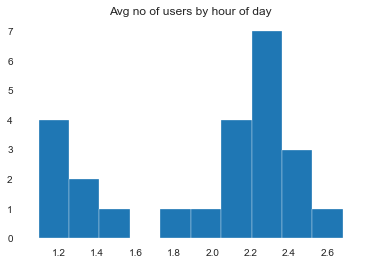

Saturday     3211
Monday       3175
Sunday       3153
Tuesday      3141
Thursday     3093
Friday       2908
Wednesday    2889
Name: weekday, dtype: int64

,weekday,avg_no_of_users
0,Friday,26.153846
1,Monday,27.880000
2,Saturday,25.461538
3,Sunday,24.423077
4,Thursday,27.500000
5,Tuesday,25.800000
6,Wednesday,25.115385


In [470]:
# High level analysis of web traffic

#3) web-traffic analysis by day of week, time of day - to check if there are some weekdays/weekends on which there is higher web traffic
# we will mesaure this using the KPI: no of unique users/visitors
# A) By the Hour: 
urldata_2020['hour'].value_counts()

avg_users_hour_1 = DataFrame(urldata_2020.groupby(['date','hour']).agg({'panelistid':['nunique']})).reset_index()
#websites_visited_per_day_1.columns = nunique_users.columns.droplevel()
avg_users_hour_1.columns = ['date','hour','nunique']

avg_users_hour_2 = DataFrame(avg_users_hour_1.groupby(['hour']).agg({'nunique':['mean']})).reset_index()
avg_users_hour_2.columns = ['hour','avg_no_of_users']

#avg_users_hour_2.head(), avg_users_hour_3.head()

plt.title('Avg no of users by hour of day')
plt.hist(avg_users_hour_2.avg_no_of_users )
plt.show()

# B) By the Day of Week: 
urldata_2020['weekday'].value_counts()

avg_users_weekday_1 = DataFrame(urldata_2020.groupby(['weekday','date']).agg({'panelistid':['nunique']})).reset_index()
#websites_visited_per_day_1.columns = nunique_users.columns.droplevel()
avg_users_weekday_1.columns = ['weekday','date','nunique']

avg_users_weekday_2 = DataFrame(avg_users_weekday_1.groupby(['weekday']).agg({'nunique':['mean']})).reset_index()
avg_users_weekday_2.columns = ['weekday','avg_no_of_users']
avg_users_weekday_2



In [ ]:
# From the above bar chart, we can see that user traffic - avg of of unique users is highest in 
#late hours in the night - 8 PM to 12 AM

# From the above table, we can see that user traffic - avg of of unique users is almost consistent across weekdays with not much variation


In [618]:
# Method to address extreme date values for timestamp:
# ------- from above analysis we can see that most users (> 85%) visit only 1 unique website per day. 
# Most of the users spend less than 5 mins per day on a average browsing the web
# Checking Outliers:

urldata.year.value_counts()


2020    21570
2071     3098
1970     1655
2070     1197
2121      866
2122      554
2172      360
2171      185
2223      166
2222      158
2173      138
2224       28
2221       24
Name: year, dtype: int64

In [702]:
# A method to address the outlier values can be:
# sort the web activity data by user and time-stamp, label the outliers,
# use and offset value from a previous non- outlier value to get the treated value of the time-stamp
# this method would work only if a particular combination of user, date has any good values for time-stamp
# this method will no work if a particular combination of user, date has only outlier values
# since there is no reference starting point on which we can derive the treated value

In [703]:
# To get the value of the offset, for a particular combination of user and date:
# get the average time-stamp between the webpages visited by the user
# in a sorted order address the outliers by adding the offset to the previous time-stamp!

In [704]:
urldata.head()

,panelistid,timestamp_utc,pageurl,datetime,date,year,month,month_name,day,weekday,week_of_month,may6th2020,week_since_6thmay2020,tld_all,tld,subdomain,hour
0,C153182421,1.602870e+09,0ruq-alternate.app.link:443,2020-10-16 17:44:12,2020-10-16,2020,10,October,16,Friday,3.0,2020-05-06,24.0,"(0ruq-alternate, app, link)",app.link,0ruq-alternate,17.0
1,C86864690,1.598914e+09,6g02fk.tdum.alibaba.com:443,2020-08-31 22:47:10,2020-08-31,2020,8,August,31,Monday,5.0,2020-05-06,17.0,"(6g02fk.tdum, alibaba, com)",alibaba.com,6g02fk.tdum,22.0
2,C2064046948,1.603043e+09,a.co,2020-10-18 17:36:57,2020-10-18,2020,10,October,18,Sunday,3.0,2020-05-06,24.0,"(, a, co)",a.co,,17.0
3,C141517021,1.601651e+09,a.co:443,2020-10-02 15:02:08,2020-10-02,2020,10,October,2,Friday,1.0,2020-05-06,22.0,"(, a, co)",a.co,,15.0
4,C2090210045,1.599200e+09,a.co:443,2020-09-04 06:08:08,2020-09-04,2020,9,September,4,Friday,1.0,2020-05-06,18.0,"(, a, co)",a.co,,6.0


In [705]:
urldata_outlier_treatment1 = urldata.sort_values(by = ['panelistid','timestamp_utc'] , ascending = [True, True])
# Labelling the Outlier Values:
#urldata_outlier_treatment1["Outlier_Flag"] = urldata_outlier_treatment1[urldata_outlier_treatment1['year'] > 2020 ]
urldata_outlier_treatment1['Outlier_Flag'] = urldata_outlier_treatment1['year'].apply(lambda x: 1 if (x !=2020) else 0)
#urldata_outlier_treatment1.head(100)
urldata_outlier_treatment1.Outlier_Flag.value_counts()

0    21570
1     8429
Name: Outlier_Flag, dtype: int64

In [706]:
# Adding a Row_number and lag values as derived columns:

 
urldata_outlier_treatment1['row_nb'] = urldata_outlier_treatment1.sort_values(['panelistid','timestamp_utc']).groupby(['panelistid']).cumcount() + 1
urldata_outlier_treatment1['last_timestamp'] = urldata_outlier_treatment1.sort_values(['panelistid','timestamp_utc']).groupby(['panelistid'])['timestamp_utc'].shift(1)

#urldata_outlier_treatment1.head(100)

In [707]:
#urldata_outlier_treatment1['last_timestamp'].loc[urldata_outlier_treatment1['Outlier_Flag'] ==1] = 0
# Get the avg time difference between time_stamp and last_time_stamp 
urldata_outlier_treatment1['difference_timestamp'] = urldata_outlier_treatment1['timestamp_utc'].astype('float') - urldata_outlier_treatment1['last_timestamp'].astype('float')
urldata_outlier_treatment1['difference_timestamp'].loc[urldata_outlier_treatment1['Outlier_Flag'] ==1] = 0

C:\Users\anuj - laptop\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [708]:
urldata_outlier_treatment1.head(100)

,panelistid,timestamp_utc,pageurl,datetime,date,year,month,month_name,day,weekday,...,may6th2020,week_since_6thmay2020,tld_all,tld,subdomain,hour,Outlier_Flag,row_nb,last_timestamp,difference_timestamp
10729,C129639566,1.600181e+09,amazon.ca/SEASUM-Leather-Leggings-Elastic-Stre...,2020-09-15 14:38:05.000000000,2020-09-15,2020,9,September,15,Tuesday,...,2020-05-06,19.0,"(, amazon, ca)",amazon.ca,,14.0,0,1,NaN,NaN
18527,C129639566,1.600189e+09,etsy.com/market/leather_lingerie,2020-09-15 16:55:36.000000000,2020-09-15,2020,9,September,15,Tuesday,...,2020-05-06,19.0,"(, etsy, com)",etsy.com,,16.0,0,2,1.600181e+09,8251.0
271,C129639566,1.600189e+09,amazon.ca,2020-09-15 16:56:00.000000000,2020-09-15,2020,9,September,15,Tuesday,...,2020-05-06,19.0,"(, amazon, ca)",amazon.ca,,16.0,0,3,1.600189e+09,24.0
5158,C129639566,1.600189e+09,amazon.ca/gp/aw/s/ref=nb_sb_ss_ts-apa-p_2_7?k=...,2020-09-15 16:56:11.000000000,2020-09-15,2020,9,September,15,Tuesday,...,2020-05-06,19.0,"(, amazon, ca)",amazon.ca,,16.0,0,4,1.600189e+09,11.0
10297,C129639566,1.600189e+09,amazon.ca/s?k=sexy+leggings+for+women&sprefix=...,2020-09-15 16:56:11.000000000,2020-09-15,2020,9,September,15,Tuesday,...,2020-05-06,19.0,"(, amazon, ca)",amazon.ca,,16.0,0,5,1.600189e+09,0.0
11096,C129639566,1.600189e+09,amazon.ca/ThreeH-Clubwear-Lingerie-Underwear-C...,2020-09-15 16:57:23.000000000,2020-09-15,2020,9,September,15,Tuesday,...,2020-05-06,19.0,"(, amazon, ca)",amazon.ca,,16.0,0,6,1.600189e+09,72.0
11337,C129639566,1.600189e+09,amazon.ca/Women-Exotic-Underwear-Babydoll-Body...,2020-09-15 16:57:56.000000000,2020-09-15,2020,9,September,15,Tuesday,...,2020-05-06,19.0,"(, amazon, ca)",amazon.ca,,16.0,0,7,1.600189e+09,33.0
8154,C129639566,1.600189e+09,amazon.ca/Rozegaga-Womens-Shoulder-Dresses-Med...,2020-09-15 17:00:24.000000000,2020-09-15,2020,9,September,15,Tuesday,...,2020-05-06,19.0,"(, amazon, ca)",amazon.ca,,17.0,0,8,1.600189e+09,148.0
11097,C129639566,1.600189e+09,amazon.ca/ThreeH-Clubwear-Lingerie-Underwear-C...,2020-09-15 17:01:17.000000000,2020-09-15,2020,9,September,15,Tuesday,...,2020-05-06,19.0,"(, amazon, ca)",amazon.ca,,17.0,0,9,1.600189e+09,53.0
11361,C129639566,1.600189e+09,amazon.ca/xinkaishi-Leather-Wetlook-Clubwear-B...,2020-09-15 17:02:45.000000000,2020-09-15,2020,9,September,15,Tuesday,...,2020-05-06,19.0,"(, amazon, ca)",amazon.ca,,17.0,0,10,1.600189e+09,88.0


In [709]:
# Getting avg difference_timestamp by user for all values that are not outliers:

urldata_outlier_treatment2 = urldata_outlier_treatment1[urldata_outlier_treatment1['Outlier_Flag'] == 0]
urldata_outlier_treatment3 = DataFrame(urldata_outlier_treatment2.groupby(['panelistid'])['difference_timestamp'].mean()).reset_index()
urldata_outlier_treatment3.columns = ['panelistid','avg_difference_timestamp']
urldata_outlier_treatment3

,panelistid,avg_difference_timestamp
0,C129639566,7.389167e+02
1,C131244695,2.608604e+04
2,C131251425,NaN
3,C131268840,2.680000e+02
4,C131293289,1.506923e+05
...,...,...
643,C92256038,4.162441e+05
644,C93297548,1.416244e+04
645,C93539742,NaN
646,C93654270,2.156310e+06


In [736]:
# Joining the dataset to get the avg value
urldata_outlier_treatment4 = urldata_outlier_treatment1.merge(urldata_outlier_treatment3, how = 'left', on=['panelistid'])
#urldata_outlier_treatment4

In [737]:
# we need to further derive an additioinal column on last_timestamp - save it in a new data set and merge with urldata_outlier_treatment4

urldata_outlier_treatment5 = DataFrame(urldata_outlier_treatment4.sort_values(['panelistid','timestamp_utc']).groupby(['panelistid','Outlier_Flag'])['last_timestamp'].nth(0)).reset_index()
urldata_outlier_treatment5.columns = ['panelistid','Outlier_Flag','base_time_stamp']
urldata_outlier_treatment6 = urldata_outlier_treatment5[urldata_outlier_treatment5['Outlier_Flag'] == 1]
urldata_outlier_treatment6
#urldata_outlier_treatment4.head(20)

,panelistid,Outlier_Flag,base_time_stamp
1,C129639566,1,1.600190e+09
3,C131244695,1,1.599823e+09
5,C131260030,1,NaN
7,C131268840,1,1.600483e+09
9,C131293289,1,1.600292e+09
11,C131299153,1,1.600525e+09
13,C131323533,1,1.602442e+09
14,C131434480,1,NaN
18,C132100627,1,1.604177e+09
20,C132104200,1,1.603548e+09


In [738]:
# joinng urldata_outlier_treatment4 and urldata_outlier_treatment6
urldata_outlier_treatment7 = urldata_outlier_treatment4.merge(urldata_outlier_treatment6, how = 'left', on = ['panelistid'])
urldata_outlier_treatment7.head(20)

,panelistid,timestamp_utc,pageurl,datetime,date,year,month,month_name,day,weekday,...,tld,subdomain,hour,Outlier_Flag_x,row_nb,last_timestamp,difference_timestamp,avg_difference_timestamp,Outlier_Flag_y,base_time_stamp
0,C129639566,1.600181e+09,amazon.ca/SEASUM-Leather-Leggings-Elastic-Stre...,2020-09-15 14:38:05,2020-09-15,2020,9,September,15,Tuesday,...,amazon.ca,,14.0,0,1,NaN,NaN,738.916667,1.0,1.600190e+09
1,C129639566,1.600189e+09,etsy.com/market/leather_lingerie,2020-09-15 16:55:36,2020-09-15,2020,9,September,15,Tuesday,...,etsy.com,,16.0,0,2,1.600181e+09,8251.0,738.916667,1.0,1.600190e+09
2,C129639566,1.600189e+09,amazon.ca,2020-09-15 16:56:00,2020-09-15,2020,9,September,15,Tuesday,...,amazon.ca,,16.0,0,3,1.600189e+09,24.0,738.916667,1.0,1.600190e+09
3,C129639566,1.600189e+09,amazon.ca/gp/aw/s/ref=nb_sb_ss_ts-apa-p_2_7?k=...,2020-09-15 16:56:11,2020-09-15,2020,9,September,15,Tuesday,...,amazon.ca,,16.0,0,4,1.600189e+09,11.0,738.916667,1.0,1.600190e+09
4,C129639566,1.600189e+09,amazon.ca/s?k=sexy+leggings+for+women&sprefix=...,2020-09-15 16:56:11,2020-09-15,2020,9,September,15,Tuesday,...,amazon.ca,,16.0,0,5,1.600189e+09,0.0,738.916667,1.0,1.600190e+09
5,C129639566,1.600189e+09,amazon.ca/ThreeH-Clubwear-Lingerie-Underwear-C...,2020-09-15 16:57:23,2020-09-15,2020,9,September,15,Tuesday,...,amazon.ca,,16.0,0,6,1.600189e+09,72.0,738.916667,1.0,1.600190e+09
6,C129639566,1.600189e+09,amazon.ca/Women-Exotic-Underwear-Babydoll-Body...,2020-09-15 16:57:56,2020-09-15,2020,9,September,15,Tuesday,...,amazon.ca,,16.0,0,7,1.600189e+09,33.0,738.916667,1.0,1.600190e+09
7,C129639566,1.600189e+09,amazon.ca/Rozegaga-Womens-Shoulder-Dresses-Med...,2020-09-15 17:00:24,2020-09-15,2020,9,September,15,Tuesday,...,amazon.ca,,17.0,0,8,1.600189e+09,148.0,738.916667,1.0,1.600190e+09
8,C129639566,1.600189e+09,amazon.ca/ThreeH-Clubwear-Lingerie-Underwear-C...,2020-09-15 17:01:17,2020-09-15,2020,9,September,15,Tuesday,...,amazon.ca,,17.0,0,9,1.600189e+09,53.0,738.916667,1.0,1.600190e+09
9,C129639566,1.600189e+09,amazon.ca/xinkaishi-Leather-Wetlook-Clubwear-B...,2020-09-15 17:02:45,2020-09-15,2020,9,September,15,Tuesday,...,amazon.ca,,17.0,0,10,1.600189e+09,88.0,738.916667,1.0,1.600190e+09


In [739]:
# Finally Getting the treated value of the timestamp = base_timestamp + offser(avg diff)


In [740]:
urldata_outlier_treatment7['new_timestamp'] = urldata_outlier_treatment7['base_time_stamp'] + (urldata_outlier_treatment7['avg_difference_timestamp'] * urldata_outlier_treatment7['row_nb'] )

In [741]:
urldata_outlier_treatment7.head(20)

,panelistid,timestamp_utc,pageurl,datetime,date,year,month,month_name,day,weekday,...,subdomain,hour,Outlier_Flag_x,row_nb,last_timestamp,difference_timestamp,avg_difference_timestamp,Outlier_Flag_y,base_time_stamp,new_timestamp
0,C129639566,1.600181e+09,amazon.ca/SEASUM-Leather-Leggings-Elastic-Stre...,2020-09-15 14:38:05,2020-09-15,2020,9,September,15,Tuesday,...,,14.0,0,1,NaN,NaN,738.916667,1.0,1.600190e+09,1.600190e+09
1,C129639566,1.600189e+09,etsy.com/market/leather_lingerie,2020-09-15 16:55:36,2020-09-15,2020,9,September,15,Tuesday,...,,16.0,0,2,1.600181e+09,8251.0,738.916667,1.0,1.600190e+09,1.600191e+09
2,C129639566,1.600189e+09,amazon.ca,2020-09-15 16:56:00,2020-09-15,2020,9,September,15,Tuesday,...,,16.0,0,3,1.600189e+09,24.0,738.916667,1.0,1.600190e+09,1.600192e+09
3,C129639566,1.600189e+09,amazon.ca/gp/aw/s/ref=nb_sb_ss_ts-apa-p_2_7?k=...,2020-09-15 16:56:11,2020-09-15,2020,9,September,15,Tuesday,...,,16.0,0,4,1.600189e+09,11.0,738.916667,1.0,1.600190e+09,1.600193e+09
4,C129639566,1.600189e+09,amazon.ca/s?k=sexy+leggings+for+women&sprefix=...,2020-09-15 16:56:11,2020-09-15,2020,9,September,15,Tuesday,...,,16.0,0,5,1.600189e+09,0.0,738.916667,1.0,1.600190e+09,1.600193e+09
5,C129639566,1.600189e+09,amazon.ca/ThreeH-Clubwear-Lingerie-Underwear-C...,2020-09-15 16:57:23,2020-09-15,2020,9,September,15,Tuesday,...,,16.0,0,6,1.600189e+09,72.0,738.916667,1.0,1.600190e+09,1.600194e+09
6,C129639566,1.600189e+09,amazon.ca/Women-Exotic-Underwear-Babydoll-Body...,2020-09-15 16:57:56,2020-09-15,2020,9,September,15,Tuesday,...,,16.0,0,7,1.600189e+09,33.0,738.916667,1.0,1.600190e+09,1.600195e+09
7,C129639566,1.600189e+09,amazon.ca/Rozegaga-Womens-Shoulder-Dresses-Med...,2020-09-15 17:00:24,2020-09-15,2020,9,September,15,Tuesday,...,,17.0,0,8,1.600189e+09,148.0,738.916667,1.0,1.600190e+09,1.600195e+09
8,C129639566,1.600189e+09,amazon.ca/ThreeH-Clubwear-Lingerie-Underwear-C...,2020-09-15 17:01:17,2020-09-15,2020,9,September,15,Tuesday,...,,17.0,0,9,1.600189e+09,53.0,738.916667,1.0,1.600190e+09,1.600196e+09
9,C129639566,1.600189e+09,amazon.ca/xinkaishi-Leather-Wetlook-Clubwear-B...,2020-09-15 17:02:45,2020-09-15,2020,9,September,15,Tuesday,...,,17.0,0,10,1.600189e+09,88.0,738.916667,1.0,1.600190e+09,1.600197e+09


In [742]:
#urldata_outlier_treatment7['new_timestamp2'] = urldata_outlier_treatment7['new_timestamp']

urldata_outlier_treatment7['new_timestamp2'] = [urldata_outlier_treatment7['timestamp_utc'] if x == 0 else urldata_outlier_treatment7['new_timestamp'] for x in urldata_outlier_treatment7['Outlier_Flag_x']]
urldata_outlier_treatment7.head(100)

#urldata_outlier_treatment7['new_timestamp2'] = np.where(urldata_outlier_treatment7['Outlier_Flag_x'] =0,urldata_outlier_treatment7['timestamp_utc'] , urldata_outlier_treatment7['new_timestamp2'])
#urldata_outlier_treatment7['new_timestamp'].iloc[urldata_outlier_treatment7['Outlier_Flag_x'] == 0] = urldata_outlier_treatment7['timestamp_utc']

,panelistid,timestamp_utc,pageurl,datetime,date,year,month,month_name,day,weekday,...,hour,Outlier_Flag_x,row_nb,last_timestamp,difference_timestamp,avg_difference_timestamp,Outlier_Flag_y,base_time_stamp,new_timestamp,new_timestamp2
0,C129639566,1.600181e+09,amazon.ca/SEASUM-Leather-Leggings-Elastic-Stre...,2020-09-15 14:38:05.000000000,2020-09-15,2020,9,September,15,Tuesday,...,14.0,0,1,NaN,NaN,738.916667,1.0,1.600190e+09,1.600190e+09,0 1.600181e+09 1 1.600189e+09 2 ...
1,C129639566,1.600189e+09,etsy.com/market/leather_lingerie,2020-09-15 16:55:36.000000000,2020-09-15,2020,9,September,15,Tuesday,...,16.0,0,2,1.600181e+09,8251.0,738.916667,1.0,1.600190e+09,1.600191e+09,0 1.600181e+09 1 1.600189e+09 2 ...
2,C129639566,1.600189e+09,amazon.ca,2020-09-15 16:56:00.000000000,2020-09-15,2020,9,September,15,Tuesday,...,16.0,0,3,1.600189e+09,24.0,738.916667,1.0,1.600190e+09,1.600192e+09,0 1.600181e+09 1 1.600189e+09 2 ...
3,C129639566,1.600189e+09,amazon.ca/gp/aw/s/ref=nb_sb_ss_ts-apa-p_2_7?k=...,2020-09-15 16:56:11.000000000,2020-09-15,2020,9,September,15,Tuesday,...,16.0,0,4,1.600189e+09,11.0,738.916667,1.0,1.600190e+09,1.600193e+09,0 1.600181e+09 1 1.600189e+09 2 ...
4,C129639566,1.600189e+09,amazon.ca/s?k=sexy+leggings+for+women&sprefix=...,2020-09-15 16:56:11.000000000,2020-09-15,2020,9,September,15,Tuesday,...,16.0,0,5,1.600189e+09,0.0,738.916667,1.0,1.600190e+09,1.600193e+09,0 1.600181e+09 1 1.600189e+09 2 ...
5,C129639566,1.600189e+09,amazon.ca/ThreeH-Clubwear-Lingerie-Underwear-C...,2020-09-15 16:57:23.000000000,2020-09-15,2020,9,September,15,Tuesday,...,16.0,0,6,1.600189e+09,72.0,738.916667,1.0,1.600190e+09,1.600194e+09,0 1.600181e+09 1 1.600189e+09 2 ...
6,C129639566,1.600189e+09,amazon.ca/Women-Exotic-Underwear-Babydoll-Body...,2020-09-15 16:57:56.000000000,2020-09-15,2020,9,September,15,Tuesday,...,16.0,0,7,1.600189e+09,33.0,738.916667,1.0,1.600190e+09,1.600195e+09,0 1.600181e+09 1 1.600189e+09 2 ...
7,C129639566,1.600189e+09,amazon.ca/Rozegaga-Womens-Shoulder-Dresses-Med...,2020-09-15 17:00:24.000000000,2020-09-15,2020,9,September,15,Tuesday,...,17.0,0,8,1.600189e+09,148.0,738.916667,1.0,1.600190e+09,1.600195e+09,0 1.600181e+09 1 1.600189e+09 2 ...
8,C129639566,1.600189e+09,amazon.ca/ThreeH-Clubwear-Lingerie-Underwear-C...,2020-09-15 17:01:17.000000000,2020-09-15,2020,9,September,15,Tuesday,...,17.0,0,9,1.600189e+09,53.0,738.916667,1.0,1.600190e+09,1.600196e+09,0 1.600181e+09 1 1.600189e+09 2 ...
9,C129639566,1.600189e+09,amazon.ca/xinkaishi-Leather-Wetlook-Clubwear-B...,2020-09-15 17:02:45.000000000,2020-09-15,2020,9,September,15,Tuesday,...,17.0,0,10,1.600189e+09,88.0,738.916667,1.0,1.600190e+09,1.600197e+09,0 1.600181e+09 1 1.600189e+09 2 ...


In [748]:
urldata_outlier_treatment7['new_timestamp3']  = urldata_outlier_treatment7[['new_timestamp','timestamp_utc']].astype('float').min()
urldata_outlier_treatment7.head(20)

,panelistid,timestamp_utc,pageurl,datetime,date,year,month,month_name,day,weekday,...,Outlier_Flag_x,row_nb,last_timestamp,difference_timestamp,avg_difference_timestamp,Outlier_Flag_y,base_time_stamp,new_timestamp,new_timestamp2,new_timestamp3
0,C129639566,1.600181e+09,amazon.ca/SEASUM-Leather-Leggings-Elastic-Stre...,2020-09-15 14:38:05,2020-09-15,2020,9,September,15,Tuesday,...,0,1,NaN,NaN,738.916667,1.0,1.600190e+09,1.600190e+09,0 1.600181e+09 1 1.600189e+09 2 ...,NaN
1,C129639566,1.600189e+09,etsy.com/market/leather_lingerie,2020-09-15 16:55:36,2020-09-15,2020,9,September,15,Tuesday,...,0,2,1.600181e+09,8251.0,738.916667,1.0,1.600190e+09,1.600191e+09,0 1.600181e+09 1 1.600189e+09 2 ...,NaN
2,C129639566,1.600189e+09,amazon.ca,2020-09-15 16:56:00,2020-09-15,2020,9,September,15,Tuesday,...,0,3,1.600189e+09,24.0,738.916667,1.0,1.600190e+09,1.600192e+09,0 1.600181e+09 1 1.600189e+09 2 ...,NaN
3,C129639566,1.600189e+09,amazon.ca/gp/aw/s/ref=nb_sb_ss_ts-apa-p_2_7?k=...,2020-09-15 16:56:11,2020-09-15,2020,9,September,15,Tuesday,...,0,4,1.600189e+09,11.0,738.916667,1.0,1.600190e+09,1.600193e+09,0 1.600181e+09 1 1.600189e+09 2 ...,NaN
4,C129639566,1.600189e+09,amazon.ca/s?k=sexy+leggings+for+women&sprefix=...,2020-09-15 16:56:11,2020-09-15,2020,9,September,15,Tuesday,...,0,5,1.600189e+09,0.0,738.916667,1.0,1.600190e+09,1.600193e+09,0 1.600181e+09 1 1.600189e+09 2 ...,NaN
5,C129639566,1.600189e+09,amazon.ca/ThreeH-Clubwear-Lingerie-Underwear-C...,2020-09-15 16:57:23,2020-09-15,2020,9,September,15,Tuesday,...,0,6,1.600189e+09,72.0,738.916667,1.0,1.600190e+09,1.600194e+09,0 1.600181e+09 1 1.600189e+09 2 ...,NaN
6,C129639566,1.600189e+09,amazon.ca/Women-Exotic-Underwear-Babydoll-Body...,2020-09-15 16:57:56,2020-09-15,2020,9,September,15,Tuesday,...,0,7,1.600189e+09,33.0,738.916667,1.0,1.600190e+09,1.600195e+09,0 1.600181e+09 1 1.600189e+09 2 ...,NaN
7,C129639566,1.600189e+09,amazon.ca/Rozegaga-Womens-Shoulder-Dresses-Med...,2020-09-15 17:00:24,2020-09-15,2020,9,September,15,Tuesday,...,0,8,1.600189e+09,148.0,738.916667,1.0,1.600190e+09,1.600195e+09,0 1.600181e+09 1 1.600189e+09 2 ...,NaN
8,C129639566,1.600189e+09,amazon.ca/ThreeH-Clubwear-Lingerie-Underwear-C...,2020-09-15 17:01:17,2020-09-15,2020,9,September,15,Tuesday,...,0,9,1.600189e+09,53.0,738.916667,1.0,1.600190e+09,1.600196e+09,0 1.600181e+09 1 1.600189e+09 2 ...,NaN
9,C129639566,1.600189e+09,amazon.ca/xinkaishi-Leather-Wetlook-Clubwear-B...,2020-09-15 17:02:45,2020-09-15,2020,9,September,15,Tuesday,...,0,10,1.600189e+09,88.0,738.916667,1.0,1.600190e+09,1.600197e+09,0 1.600181e+09 1 1.600189e+09 2 ...,NaN


In [ ]:
getting the correcponding year of treated outlier vlues